# Intro

The end goal will be to build a linear regression model that predicts price from the various features in the data set.

# Preparations

In [1]:
# Import the packages
import csv, sqlite3 
import pandas as pd
import numpy as np
!pip install ipython-sql

# Establish the SQL database
con = sqlite3.connect("autodb.db")
cur = con.cursor()
# Connect to it
%load_ext sql
%sql sqlite:///autodb.db
# Load the data from auto.csv
df = pd.read_csv("auto.csv")
df.to_sql("AUTO",con,if_exists='replace',index=False,method="multi")

204

Now that the database is prepared, I'll quickly test to see if everything is loaded up properly. I realize this is perhaps a bit redundant, but I'm really just trying to practice my SQL stuff now that I've finished that course.

In [2]:
%%sql
SELECT * FROM AUTO LIMIT 5;

 * sqlite:///autodb.db
Done.


3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
2,?,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


## Cleaning

Okay, so I can immediately see some issues. First problem is the fact that there's no actual header, second is that I'm going to need to go through and figure out how to deal with those missing values. As I'm going along here, I'm realizing that really, most of my work is going to be done in Pandas, so with regards to the SQL aspect, I think I'll focus on just creating the database with the cleaned data at the end.

In [3]:
# Assign headers to a list of strings
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]
df.columns = headers # Update the underlying dataframe
df.to_sql("AUTO",con,if_exists='replace',index=False,method="multi") # Overwrite the data in the database.
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


Next, I'm going to determine the number of missing values in each column.

In [4]:
# Replace "?" with NA
df.replace('?',np.nan,inplace=True)
df.isna().sum()

symboling             0
normalized-losses    40
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

So, we can see that 40 of the normalized loss values are missing. That just will not do. We don't want to drop 40 rows from our data-set, so we'll find the mean of the remaining values and substitute it in

In [5]:
#mean = df["normalized-losses"].mean()
#df["normalized-losses"].replace(np.nan,mean)

Okay, so that doesn't work yet, because the Normalized Losses column is an object column, not float or int. So, I'll have to go through and correct the type of each column first.

## Converting Types

I'll have to change a lot of these columns to the proper type.

In [6]:
pd.set_option('display.max_columns', None) 
df.info()
df.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          204 non-null    int64  
 1   normalized-losses  164 non-null    object 
 2   make               204 non-null    object 
 3   fuel-type          204 non-null    object 
 4   aspiration         204 non-null    object 
 5   num-of-doors       202 non-null    object 
 6   body-style         204 non-null    object 
 7   drive-wheels       204 non-null    object 
 8   engine-location    204 non-null    object 
 9   wheel-base         204 non-null    float64
 10  length             204 non-null    float64
 11  width              204 non-null    float64
 12  height             204 non-null    float64
 13  curb-weight        204 non-null    int64  
 14  engine-type        204 non-null    object 
 15  num-of-cylinders   204 non-null    object 
 16  engine-size        204 non

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


In [7]:
# Create a list of columns to change the type of in a simple way
cols = ["normalized-losses","bore","stroke","horsepower","peak-rpm","price"]

In [8]:
for col in cols:
    df[col] = df[col].astype("float64")

Now, another problem I can see here is the fact that "num-of-cylinders" is written as a bunch of strings, even though it should be an integer. Time to fix that...

In [9]:
df["num-of-cylinders"].unique()

array(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'],
      dtype=object)

Now I'll create a dictionary with each 'num-of-cylinders' value as the key and the equivalent numerical value as the value, then use a "for" loop to iterate through and replace them all

In [10]:
# Create the dictionary
dict = {'four':4,'six':6,'five':5,'three':3,'twelve':12,'two':2,'eight':8}
# Loop through the data frame and replace
for key,value in dict.items():
    df["num-of-cylinders"] = df["num-of-cylinders"].replace(key,value)
df["num-of-cylinders"] = df["num-of-cylinders"].astype("object")

In [11]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
1,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
2,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
3,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
4,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,5,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0


With that done, I can finally fix that normalized-losses column

In [12]:
mean = df["normalized-losses"].mean()
df["normalized-losses"] = df["normalized-losses"].replace(np.nan,mean)

In [13]:
df.to_sql("AUTO",con,if_exists='replace',index=False,method="multi")
%sql SELECT * FROM AUTO LIMIT 5;

 * sqlite:///autodb.db
Done.


symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
1,122.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0
2,122.0,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,5,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,15250.0


# Data Wrangling

In [14]:
# Evaluate for missing data
missing_data = df.isnull()

# Count missing values in each column
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print('')

symboling
False    204
Name: symboling, dtype: int64

normalized-losses
False    204
Name: normalized-losses, dtype: int64

make
False    204
Name: make, dtype: int64

fuel-type
False    204
Name: fuel-type, dtype: int64

aspiration
False    204
Name: aspiration, dtype: int64

num-of-doors
False    202
True       2
Name: num-of-doors, dtype: int64

body-style
False    204
Name: body-style, dtype: int64

drive-wheels
False    204
Name: drive-wheels, dtype: int64

engine-location
False    204
Name: engine-location, dtype: int64

wheel-base
False    204
Name: wheel-base, dtype: int64

length
False    204
Name: length, dtype: int64

width
False    204
Name: width, dtype: int64

height
False    204
Name: height, dtype: int64

curb-weight
False    204
Name: curb-weight, dtype: int64

engine-type
False    204
Name: engine-type, dtype: int64

num-of-cylinders
False    204
Name: num-of-cylinders, dtype: int64

engine-size
False    204
Name: engine-size, dtype: int64

fuel-system
False    204
Na

We can see now that we're still missing values in the bore, stroke, horsepower, peak-rpm, and price columns. If we're missing price data, then there's no point (assuming we want to create a model for price). Number of doors is a categorical variable, so that should be replaced by the mode. For the others, we'll replace the missing values with the mean. 

In [15]:
# Find most common value in number of doors and replace missing values
df["num-of-doors"].replace(np.nan,df["num-of-doors"].value_counts().idxmax(), inplace=True)

In [16]:
# Drop rows with missing prices
df.dropna(subset=["price"],axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)

In [17]:
# Create a list of columns that need to have missing values replaced by the mean
to_replace = ["bore","stroke","horsepower","peak-rpm"]

# Loop through the columns, replace missing values as needed
for col in to_replace:
    mean = df[col].mean()
    df[col].replace(np.nan,mean,inplace=True)

## Introducing indicator variables

If our endgoal is a machine learning model for price based on the other variables, then we'll need to replace the categorical variables with indicator variables. Those categorical variables are:
- make
- fuel-type
- aspiration
- num-of-doors
- body-style
- drive-wheels
- engine-location
- engine-type
- fuel-system
- num-of-cylinders

In [18]:
# Create a list of Object type columns
to_replace = []
for col in list(df):
    if df[col].dtype == np.object_:
        to_replace.append(col)

# Iterate through list and replace each column with an indicator variable
for col in to_replace:
    dv = pd.get_dummies(df[col])
    df = pd.concat([df,dv],axis=1)
    df.drop(col,axis=1,inplace=True)

df.head()

C:\Users\lucfi\AppData\Local\Temp\ipykernel_48940\1727623971.py:9: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dv = pd.get_dummies(df[col])


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,alfa-romero,audi,bmw,chevrolet,dodge,honda,isuzu,jaguar,mazda,mercedes-benz,mercury,mitsubishi,nissan,peugot,plymouth,porsche,renault,saab,subaru,toyota,volkswagen,volvo,diesel,gas,std,turbo,four,two,convertible,hardtop,hatchback,sedan,wagon,4wd,fwd,rwd,front,rear,dohc,l,ohc,ohcf,ohcv,rotor,2,3,4,5,6,8,12,1bbl,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi
0,3,122.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,1,122.0,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,2,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,2,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,2,122.0,99.8,177.3,66.3,53.1,2507,136,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


That feels like a ridiculous number of columns, but when we really think about it, something like a multiple-regression model would actually allow us to have greater insight into the relationship between manufacuturers, etc. if we had a dummy variable for each in this manner.

# Exploration and Modeling

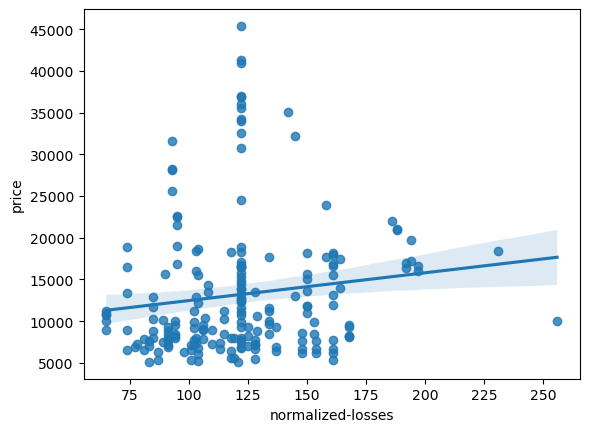

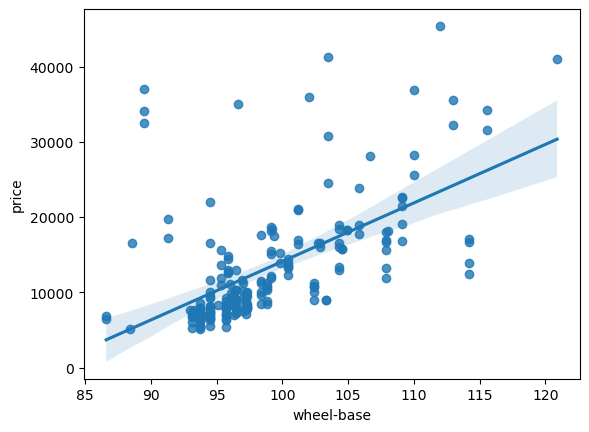

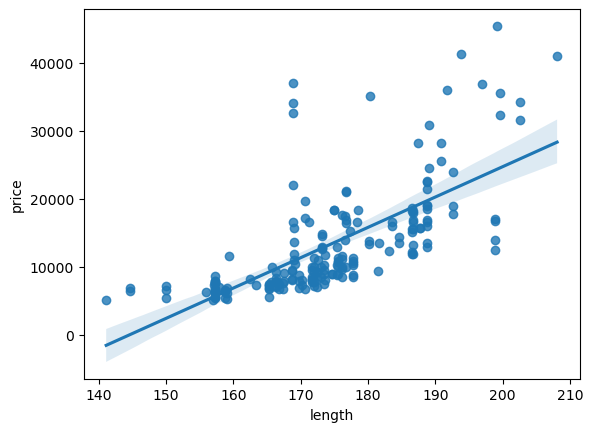

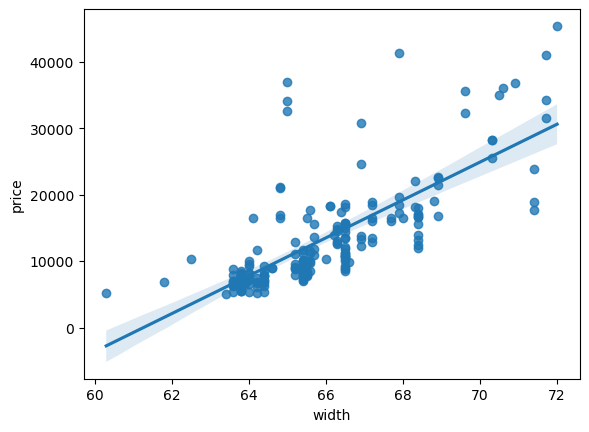

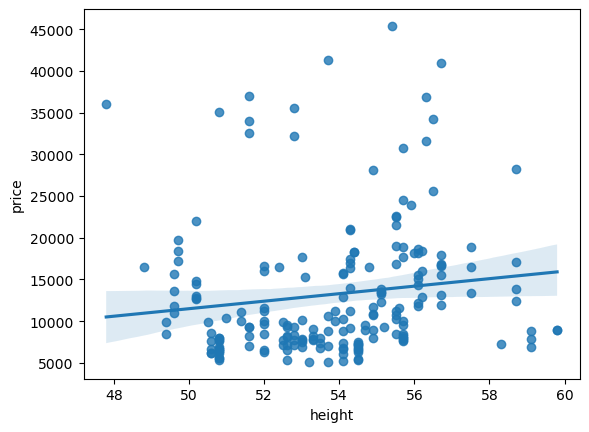

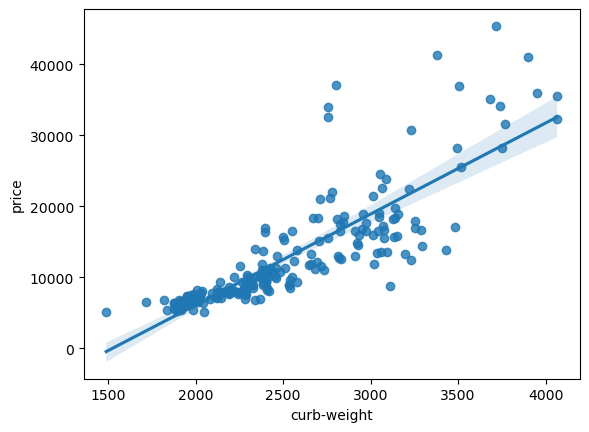

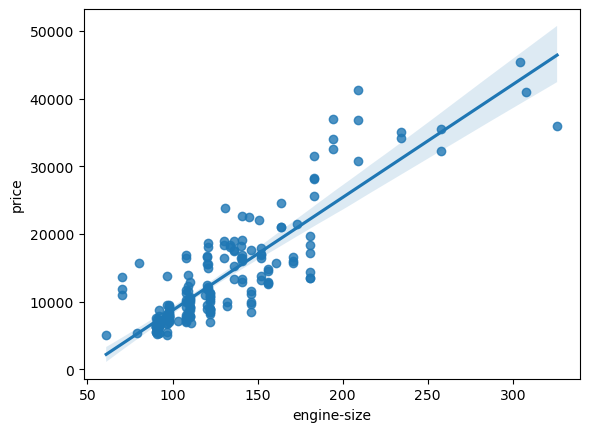

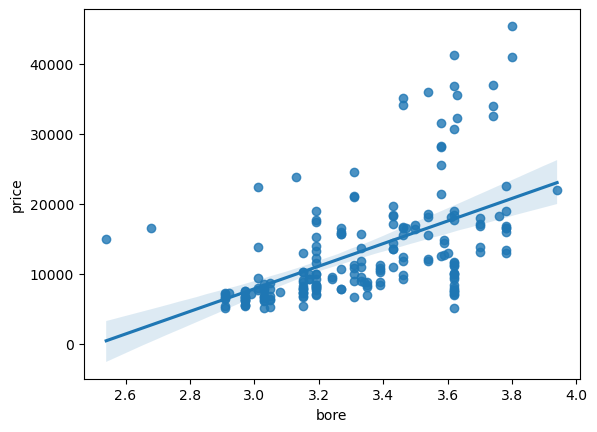

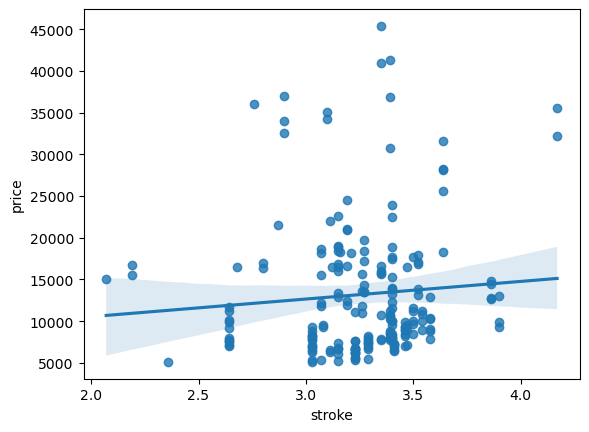

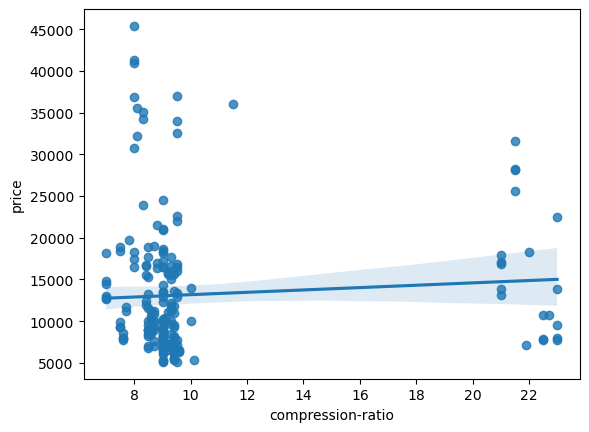

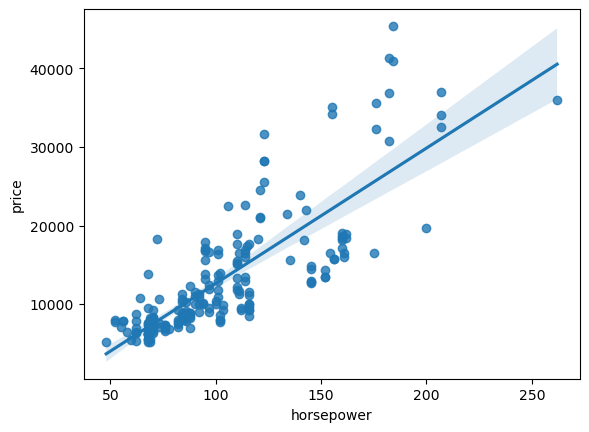

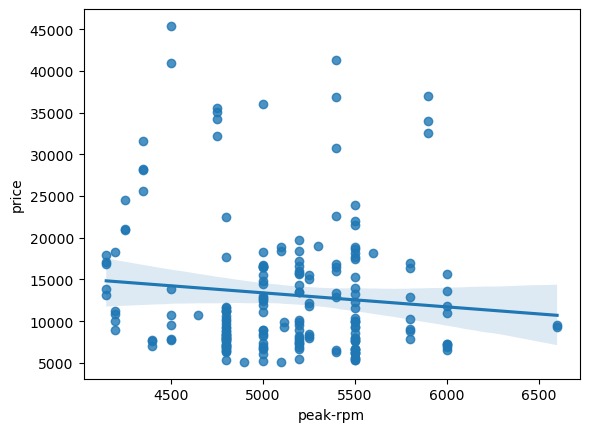

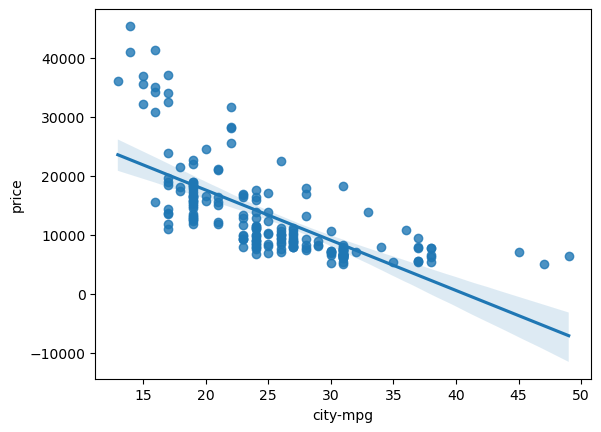

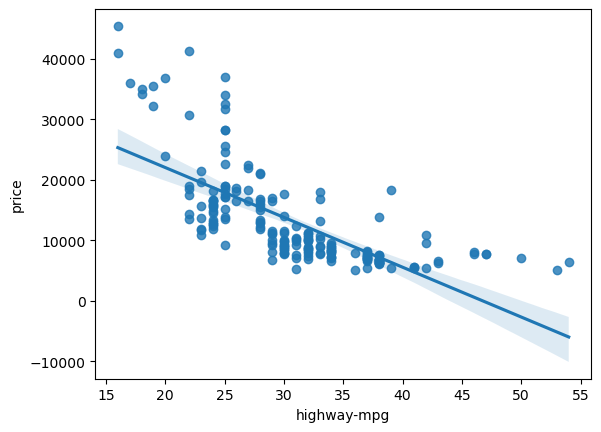

In [19]:
# Import libraries for EDA
import seaborn as sns
import matplotlib.pyplot as plt

# Get single linear regression plots for each of the quantitative variables to understand relationships.
quant_vars = ["normalized-losses","wheel-base","length","width","height","curb-weight","engine-size","bore","stroke","compression-ratio","horsepower","peak-rpm","city-mpg","highway-mpg"]
y_data = df["price"]


for var in quant_vars:
    sns.regplot(x=var, y="price", data = df)
    plt.show()

In [20]:
var = quant_vars[0]
#print(f"Correlation between {var} and price: ",df[[var,'price']].corr())


Correlation between price and volume:  0.6310159113895106


<Axes: xlabel='volume', ylabel='price'>

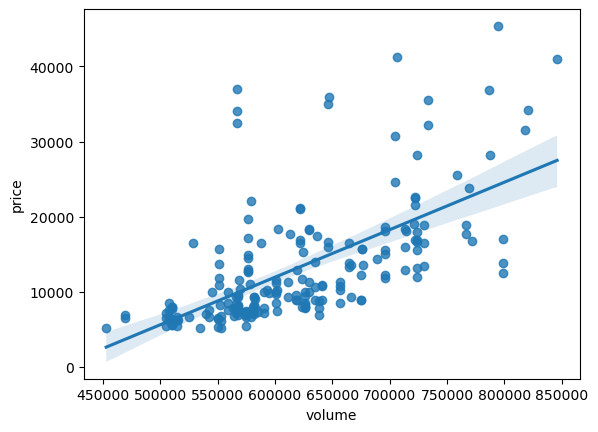

In [21]:
# One idea I just had... maybe consolidate length, width, and height into a single "volume" feature? 
# I don't expect price to be related to each one significantly, but the volume is a maybe
volume = df['length']*df['width']*df['height']
volume = pd.DataFrame(volume,columns=["volume"])
df_new = pd.concat([df,volume],axis=1)
df_new.drop(['length','width','height'],axis=1,inplace=True)

print("Correlation between price and volume: ",df_new['volume'].corr(df['price']))
sns.regplot(x='volume',y='price',data=df_new)

# Okay, so overall volume is less significantly correlated with price than width or length individually were. Looks like it's best to stick with them separate, but I'll keep that in my back pocket.

## Feature Selection

In [22]:
# Calculate the correlation between each feature and the price, then sort by magnitude.
corr = list()
for var in quant_vars:
    corr.append([var, df[var].corr(df['price'])])
    print(f"Correlation between {var} and price: {df[var].corr(df['price']):0.2f}")

corr_sort = sorted(corr, key=lambda corr: abs(corr[1]),reverse=True)
corr_sort

Correlation between normalized-losses and price: 0.13
Correlation between wheel-base and price: 0.59
Correlation between length and price: 0.69
Correlation between width and price: 0.75
Correlation between height and price: 0.14
Correlation between curb-weight and price: 0.83
Correlation between engine-size and price: 0.87
Correlation between bore and price: 0.54
Correlation between stroke and price: 0.08
Correlation between compression-ratio and price: 0.07
Correlation between horsepower and price: 0.81
Correlation between peak-rpm and price: -0.10
Correlation between city-mpg and price: -0.69
Correlation between highway-mpg and price: -0.71


[['engine-size', 0.8723367498521148],
 ['curb-weight', 0.8344204348498461],
 ['horsepower', 0.8097357390985228],
 ['width', 0.7527948631832596],
 ['highway-mpg', -0.70511470880464],
 ['length', 0.691044089782191],
 ['city-mpg', -0.6871861020862683],
 ['wheel-base', 0.5891470005448703],
 ['bore', 0.5434310033088077],
 ['height', 0.137283525252906],
 ['normalized-losses', 0.13399917605642037],
 ['peak-rpm', -0.10151867271331243],
 ['stroke', 0.0832956106403976],
 ['compression-ratio', 0.07117559170681713]]

In [23]:
# Can see that there is a significant gap in correlation from 0.14 to 0.54. Let's exclude the features with correlation less than 0.54.
high_corr=[]
for var in corr_sort:
    if abs(var[1])>0.5:
        high_corr.append(var)
high_corr = np.array(high_corr)
print(high_corr[:,0])

['engine-size' 'curb-weight' 'horsepower' 'width' 'highway-mpg' 'length'
 'city-mpg' 'wheel-base' 'bore']


In [24]:
# Create a new data frame with just the high correlation Xs and the indicators
# Do this by dropping the low correlation Xs
low_corr=[]
for var in corr_sort:
    if abs(var[1])<0.5:
        low_corr.append(var)
low_corr = np.array(low_corr)
print(low_corr[:,0])
df_new = df.drop(low_corr[:,0],axis=1)

['height' 'normalized-losses' 'peak-rpm' 'stroke' 'compression-ratio']


In [25]:
df_new

,symboling,wheel-base,length,width,curb-weight,engine-size,bore,horsepower,city-mpg,highway-mpg,price,alfa-romero,audi,bmw,chevrolet,dodge,honda,isuzu,jaguar,mazda,mercedes-benz,mercury,mitsubishi,nissan,peugot,plymouth,porsche,renault,saab,subaru,toyota,volkswagen,volvo,diesel,gas,std,turbo,four,two,convertible,hardtop,hatchback,sedan,wagon,4wd,fwd,rwd,front,rear,dohc,l,ohc,ohcf,ohcv,rotor,2,3,4,5,6,8,12,1bbl,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi
0,3,88.6,168.8,64.1,2548,130,3.47,111.0,21,27,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,1,94.5,171.2,65.5,2823,152,2.68,154.0,19,26,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,2,99.8,176.6,66.2,2337,109,3.19,102.0,24,30,13950.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,2,99.4,176.6,66.4,2824,136,3.19,115.0,18,22,17450.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,2,99.8,177.3,66.3,2507,136,3.19,110.0,19,25,15250.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-1,109.1,188.8,68.9,2952,141,3.78,114.0,23,28,16845.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
196,-1,109.1,188.8,68.8,3049,141,3.78,160.0,19,25,19045.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
197,-1,109.1,188.8,68.9,3012,173,3.58,134.0,18,23,21485.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
198,-1,109.1,188.8,68.9,3217,145,3.01,106.0,26,27,22470.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [26]:
## Need to load up the original data set for this part of the EDA. Have to repeat basically everything up to the point of introducing the indicator vars
dfWithCategories = pd.read_csv("auto.csv")
# Assign headers to a list of strings
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]
dfWithCategories.columns = headers # Update the underlying dataframe
# Replace "?" with NA
dfWithCategories.replace('?',np.nan,inplace=True)
dfWithCategories.isna().sum()
# Create a list of columns to change the type of in a simple way
cols = ["normalized-losses","bore","stroke","horsepower","peak-rpm","price"]
for col in cols:
    dfWithCategories[col] = dfWithCategories[col].astype("float64")
mean = dfWithCategories["normalized-losses"].mean()
dfWithCategories["normalized-losses"] = dfWithCategories["normalized-losses"].replace(np.nan,mean)
# Find most common value in number of doors and replace missing values
dfWithCategories["num-of-doors"].replace(np.nan,dfWithCategories["num-of-doors"].value_counts().idxmax(), inplace=True)
dfWithCategories.dropna(subset=["price"],axis=0,inplace=True)
dfWithCategories.reset_index(drop=True,inplace=True)
# Create a list of columns that need to have missing values replaced by the mean
to_replace = ["bore","stroke","horsepower","peak-rpm"]

# Loop through the columns, replace missing values as needed
for col in to_replace:
    mean = dfWithCategories[col].mean()
    dfWithCategories[col].replace(np.nan,mean,inplace=True)

# Create a list of Object type columns
qual_vars = []
for col in list(dfWithCategories):
    if dfWithCategories[col].dtype == np.object_:
        qual_vars.append(col)

qual_vars

['make',
 'fuel-type',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'engine-type',
 'num-of-cylinders',
 'fuel-system']

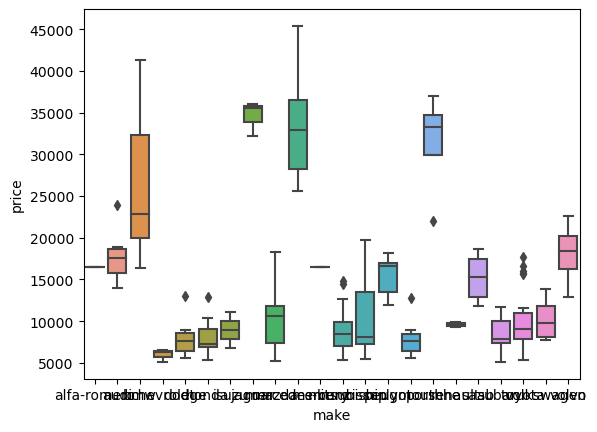

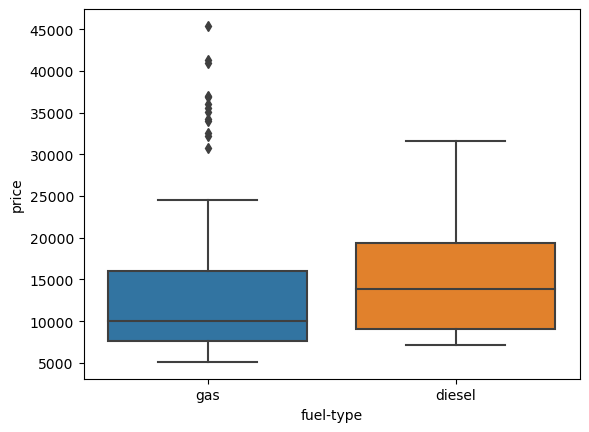

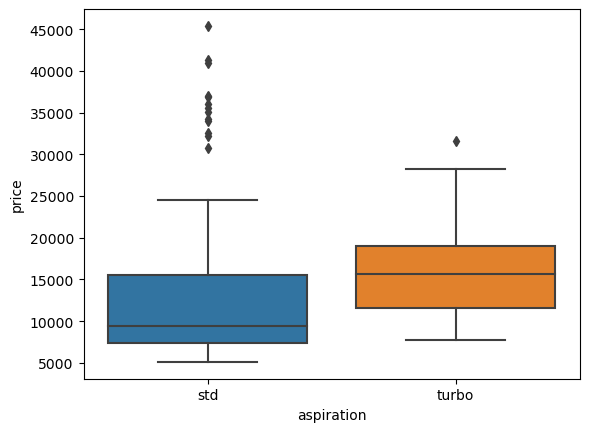

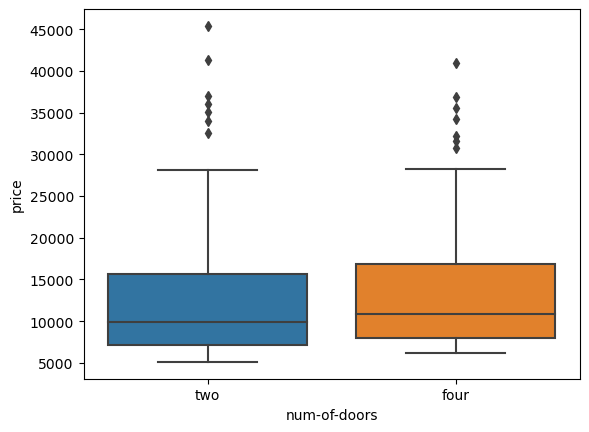

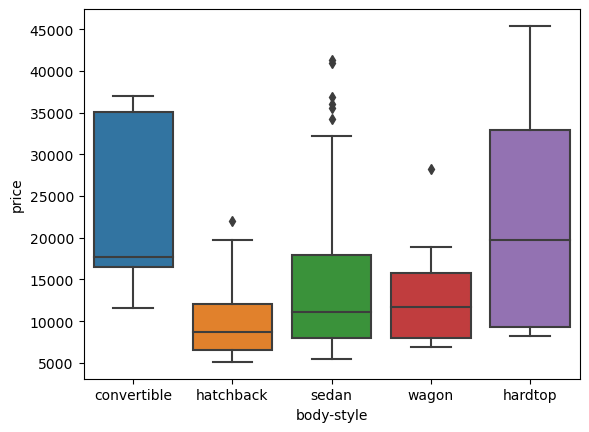

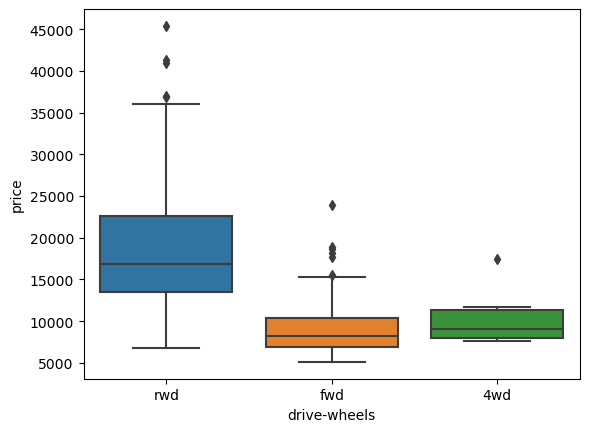

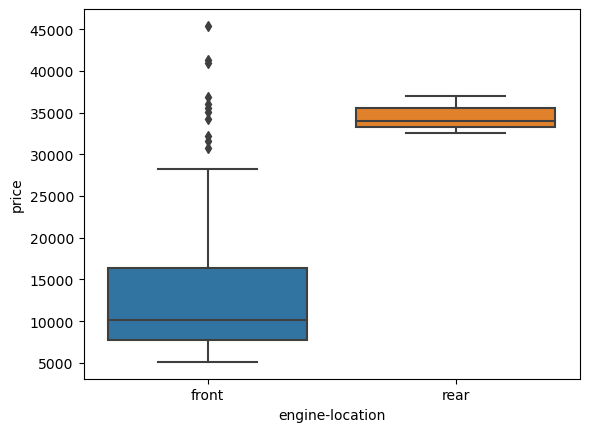

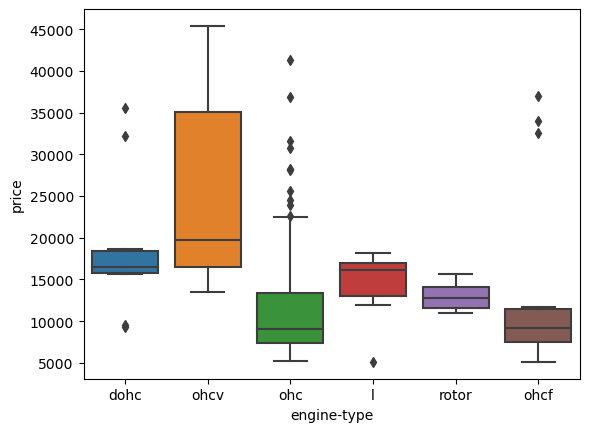

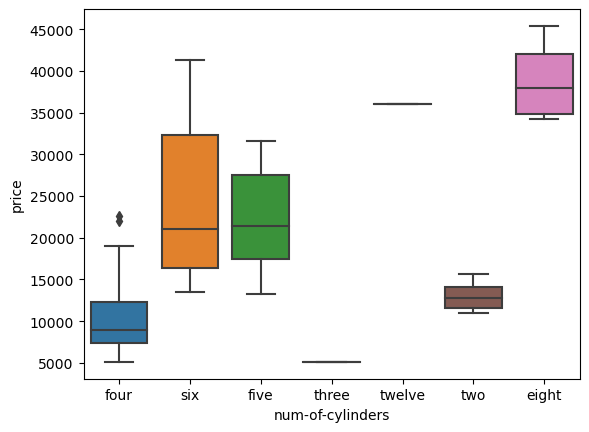

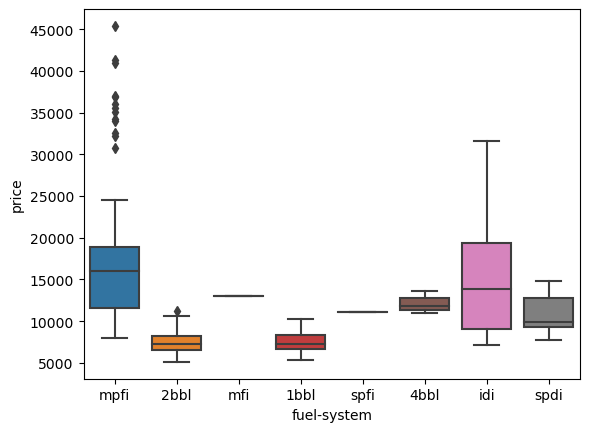

In [27]:
# Create the box plots
for type in qual_vars:
    sns.boxplot(x=type, y='price',data=dfWithCategories)
    plt.show()

<Axes: xlabel='price', ylabel='make'>

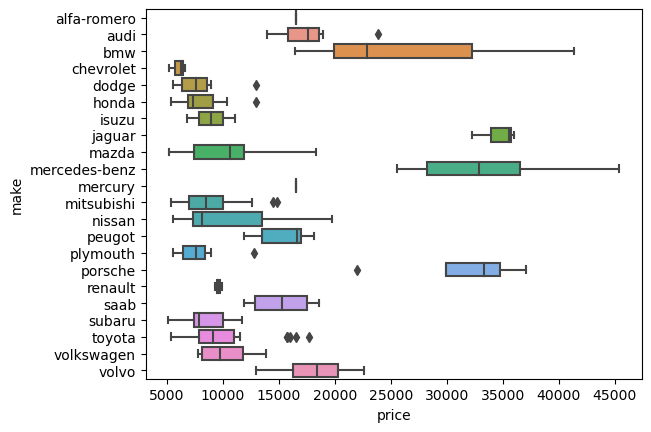

In [28]:
# The make plot is illegible. Turn labels sideways
sns.boxplot(y=qual_vars[0], x='price',data=dfWithCategories,orient = "h")

<Axes: xlabel='price', ylabel='make'>

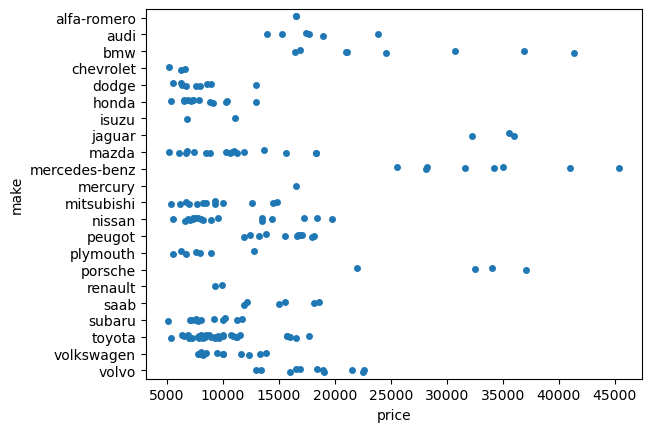

In [29]:
# The make plot is illegible. Turn labels sideways
sns.stripplot(y=qual_vars[0], x='price',data=dfWithCategories,orient = "h")

## EDA Insights:
- Diesel has a wider spread of prices. This likely reflects a smaller number of samples. It tends to be a little more expensive, but not by much.
- As one would expect, convertibles tend to be more expensive. Hardtops have the widest spread
- Rear wheel drive vehicles tend to be more expensive, but also have a much wider spread. Larger sample size?
- Cars with a rear engine are much more expensive on average. They're also more rare.
- Eight cylinder vehicles are typically more expensive than other types.
- Jaguar has the highest median price, while Mercedes-Benz has the highest price in the data set. Chevrolet has the lowest prices overall. BMW has the widest spread in prices, while Renault has the smallest (that probably indicates it's just the smallest sample size.
- Making definitive statements about the spread of prices based on the make is hard, because some of the makes have very few data points.

## Modeling

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lm = LinearRegression()

#Split the data into x and y
y_data = df_new[['price']]
x_data = df_new.drop('price',axis=1)


#Fix a complaint about column types
x_data.columns = x_data.columns.astype(str)

# Split the data for training and test
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.4)

#Fit the model
lm.fit(x_train,y_train)

LinearRegression()

## Evaluation

In [44]:
# Find R^2 on test data
print("Model R^2: ", lm.score(x_test,y_test))

Model R^2:  0.8991113841288764


In [45]:
from sklearn.model_selection import cross_val_score
#Cross validation:
Rcross = cross_val_score(lm,x_data,y_data,cv=4)
print("Cross Validated R^2: ", Rcross)

Cross Validated R^2:  [ 0.67129463  0.66023649  0.22779789 -0.14937264]


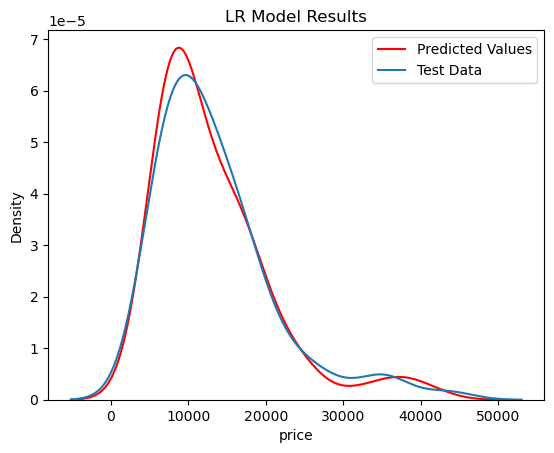

Correlation between prediction and observation:  0.9526327773094636


In [96]:
#Generate the prediction
yhat = lm.predict(x_test)

#Create the plots
fig, ax = plt.subplots()
line1=sns.kdeplot(data=y_test.squeeze(), ax = ax, color = 'red', label="Test Data")
line2=sns.kdeplot(data=yhat.squeeze(),ax = ax, label="Predicted")
ax.legend(['Predicted Values','Test Data'])
ax.set_title("LR Model Results")
plt.show()

yhat_df = pd.DataFrame(yhat,columns=["predicted"])
test_df= pd.concat([yhat_df.reset_index(),y_test.reset_index()],axis=1)
print("Correlation between prediction and observation: ", test_df['predicted'].corr(test_df['price']))

## Refinement

In [ ]:
# Since the quantitative features vary in scale, lets try standardizing them first. 
# I could not get this working just yet...

# Conclusion
The multiple linear regression model appears to perform fairly well. The most significant point of concern is the fact that, as shown in the cross validation stage, the coefficient of determination changes significantly depending on which fold is being used to test and which is being used to train. This suggests that because of the small number of observations in the very high range, the model isn't able to accurately capture the behavior there. Contextually, one might expect that if someone is selling a BMW or a Benz, then things like the condition of the vehicle may have less of an impact than in lower price ranges. As such, a different model for higher priced cars may be necessary.

All of that being said, having a correlation between prediction and observation in the test region of 95.26^